In [ ]:
# %%capture
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bibekchalise","key":"53b5557999a6db293e648ba8d77affc6"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

5-flower-types-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

 5-flower-types-classification-dataset.zip  'kaggle (1).json'   sample_data
 flower_images				     kaggle.json


In [ ]:
%%capture
!unzip 5-flower-types-classification-dataset.zip

In [ ]:
data_dir = '/content/flower_images'

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import glob, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch.nn as nn
!pip install torch_summary
from torchvision import transforms, models, datasets
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
path = glob.glob(data_dir+'/*/*')

In [ ]:
df = pd.DataFrame(path, columns=['path'])

In [ ]:
df['label'] = df['path'].apply(lambda x: x.split('/')[-2])

In [ ]:
df

,path,label
0,/content/flower_images/Orchid/e67e5ee3ef.jpg,Orchid
1,/content/flower_images/Orchid/ff7f9acb69.jpg,Orchid
2,/content/flower_images/Orchid/1c81df0661.jpg,Orchid
3,/content/flower_images/Orchid/5c307bc9c1.jpg,Orchid
4,/content/flower_images/Orchid/102f1b77ea.jpg,Orchid
...,...,...
4995,/content/flower_images/Lotus/0c58cee30f.jpg,Lotus
4996,/content/flower_images/Lotus/de8ad9aa08.jpg,Lotus
4997,/content/flower_images/Lotus/eb32def629.jpg,Lotus
4998,/content/flower_images/Lotus/b768a0fb74.jpg,Lotus


In [ ]:
df.label.value_counts()

Orchid       1000
Lilly        1000
Sunflower    1000
Tulip        1000
Lotus        1000
Name: label, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df.label = le.fit_transform(df.label)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}


In [ ]:
df

,path,label
0,/content/flower_images/Orchid/e67e5ee3ef.jpg,2
1,/content/flower_images/Orchid/ff7f9acb69.jpg,2
2,/content/flower_images/Orchid/1c81df0661.jpg,2
3,/content/flower_images/Orchid/5c307bc9c1.jpg,2
4,/content/flower_images/Orchid/102f1b77ea.jpg,2
...,...,...
4995,/content/flower_images/Lotus/0c58cee30f.jpg,1
4996,/content/flower_images/Lotus/de8ad9aa08.jpg,1
4997,/content/flower_images/Lotus/eb32def629.jpg,1
4998,/content/flower_images/Lotus/b768a0fb74.jpg,1


In [ ]:
df.label.value_counts()

2    1000
0    1000
3    1000
4    1000
1    1000
Name: label, dtype: int64

In [ ]:
class FlowerDataset(Dataset):
  def __init__(self, df):
    self.df = df
    self.fpaths = df.path
    self.targets = df.label

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):

        f = self.fpaths[ix]
        target = (self.targets[ix])
        im = cv2.imread(f)[:,:,::-1]
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor(target).long().to(device)


In [ ]:
data = FlowerDataset(df)

In [ ]:
im, label = data[100]

tensor(2, device='cuda:0')


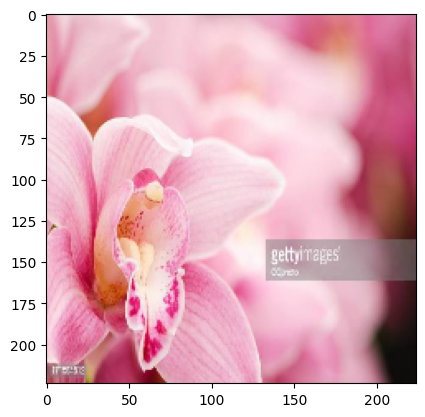

In [ ]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
train_df, val_df = train_test_split(df, stratify=df.label, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [ ]:
def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

In [ ]:
def get_model():
    model = torchvision.models.vgg16(pretrained=True)
    for param in model.features.parameters():
                   param.requires_grad = False
    model.avgpool = model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Linear(512, 128),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(128, 5),
                                   nn.Sigmoid())
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [ ]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224));

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [ ]:
def get_data():
  train = FlowerDataset(train_df)
  trn_dl = DataLoader(train, batch_size=16,shuffle=True, drop_last=True)
  val = FlowerDataset(val_df)
  val_dl = DataLoader(val, batch_size=16, shuffle=True, drop_last=True)
  return trn_dl, val_dl

In [ ]:
def train_batch(x, y, model,  loss_fn,opt):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  pred = model(x)
  _, is_correct = torch.max(pred.data,1)
  acc_all = (is_correct==y).detach().cpu().numpy()
  return acc_all

In [ ]:
@torch.no_grad()
def val_loss_trn(x, y, model, loss_fn):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)

  return val_loss.item()

In [ ]:
trn_ldr, test_ldr = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
import time
from tqdm import tqdm
start_time = time.time()

train_loss = []
train_accuracies= []
val_loss = []
val_accuracies = []

for i in range(25):
  print(f'Epoch: _________*****{i}*****_______')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies, val_epoch_losses = [], []



  for ix, batch in tqdm((enumerate(iter(trn_ldr))), total=len(trn_ldr)):
      x, y = batch
      train_epoch_losses.append(train_batch(x, y, model, loss_fn, optimizer))
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Training Loss : {train_epoch_loss} *****_______')



  for ix, batch in tqdm((enumerate(iter(trn_ldr))), total=len(trn_ldr)):
    x, y = batch
    train_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  train_epoch_accuracy = np.array(train_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Training Accuracy: {train_epoch_accuracy} *****_______')



  for ix, batch in tqdm((enumerate(iter(test_ldr))), total=len(test_ldr)):
    x, y = batch
    val_epoch_losses.append(val_loss_trn(x, y, model, loss_fn))
  val_epoch_loss = np.array(val_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Validation Loss : {val_epoch_loss} *****_______')

  for ix, batch in tqdm((enumerate(iter(test_ldr))), total=len(test_ldr)):
    x, y = batch
    val_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  val_epoch_accuracy = np.array(val_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Validation Accuracy. {val_epoch_accuracy} *****_______')
  print('\n')

  train_loss.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  val_loss.append(val_epoch_loss)

Epoch: _________*****0*****_______


100%|██████████| 234/234 [00:58<00:00,  4.00it/s]


Epoch: _________*****0 Training Loss : 1.3175854428201659 *****_______


100%|██████████| 234/234 [00:51<00:00,  4.57it/s]


Epoch: _________*****0 Training Accuracy: 0.8167735042735043 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.63it/s]


Epoch: _________*****0 Validation Loss : 1.1625844820951805 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch: _________*****0 Validation Accuracy. 0.7956730769230769 *****_______


Epoch: _________*****1*****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****1 Training Loss : 1.1247518773262317 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****1 Training Accuracy: 0.8469551282051282 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.49it/s]


Epoch: _________*****1 Validation Loss : 1.1051089656658661 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.73it/s]


Epoch: _________*****1 Validation Accuracy. 0.8229166666666666 *****_______


Epoch: _________*****2*****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****2 Training Loss : 1.0828652310575175 *****_______


100%|██████████| 234/234 [00:49<00:00,  4.68it/s]


Epoch: _________*****2 Training Accuracy: 0.8643162393162394 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.51it/s]


Epoch: _________*****2 Validation Loss : 1.0804542303085327 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.70it/s]


Epoch: _________*****2 Validation Accuracy. 0.8397435897435898 *****_______


Epoch: _________*****3*****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****3 Training Loss : 1.0583140106282682 *****_______


100%|██████████| 234/234 [00:49<00:00,  4.69it/s]


Epoch: _________*****3 Training Accuracy: 0.8774038461538461 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.74it/s]


Epoch: _________*****3 Validation Loss : 1.0699233275193434 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.51it/s]


Epoch: _________*****3 Validation Accuracy. 0.8501602564102564 *****_______


Epoch: _________*****4*****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****4 Training Loss : 1.042363898876386 *****_______


100%|██████████| 234/234 [00:49<00:00,  4.68it/s]


Epoch: _________*****4 Training Accuracy: 0.8840811965811965 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.74it/s]


Epoch: _________*****4 Validation Loss : 1.0583911729164612 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.51it/s]


Epoch: _________*****4 Validation Accuracy. 0.8589743589743589 *****_______


Epoch: _________*****5*****_______


100%|██████████| 234/234 [00:50<00:00,  4.68it/s]


Epoch: _________*****5 Training Loss : 1.031986706277244 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.68it/s]


Epoch: _________*****5 Training Accuracy: 0.8867521367521367 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch: _________*****5 Validation Loss : 1.0597639488868225 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.76it/s]


Epoch: _________*****5 Validation Accuracy. 0.8461538461538461 *****_______


Epoch: _________*****6*****_______


100%|██████████| 234/234 [00:50<00:00,  4.62it/s]


Epoch: _________*****6 Training Loss : 1.0222388561974225 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****6 Training Accuracy: 0.8990384615384616 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.70it/s]


Epoch: _________*****6 Validation Loss : 1.0447617776882954 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.75it/s]


Epoch: _________*****6 Validation Accuracy. 0.8653846153846154 *****_______


Epoch: _________*****7*****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****7 Training Loss : 1.0138011656255803 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****7 Training Accuracy: 0.9102564102564102 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.56it/s]


Epoch: _________*****7 Validation Loss : 1.0417876419348595 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch: _________*****7 Validation Accuracy. 0.8685897435897436 *****_______


Epoch: _________*****8*****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****8 Training Loss : 1.0055882882358682 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****8 Training Accuracy: 0.9145299145299145 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.51it/s]


Epoch: _________*****8 Validation Loss : 1.0358291933169732 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.69it/s]


Epoch: _________*****8 Validation Accuracy. 0.8725961538461539 *****_______


Epoch: _________*****9*****_______


100%|██████████| 234/234 [00:50<00:00,  4.62it/s]


Epoch: _________*****9 Training Loss : 1.000684449305901 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****9 Training Accuracy: 0.9123931623931624 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


Epoch: _________*****9 Validation Loss : 1.0434869757065406 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.69it/s]


Epoch: _________*****9 Validation Accuracy. 0.8629807692307693 *****_______


Epoch: _________*****10*****_______


100%|██████████| 234/234 [00:50<00:00,  4.62it/s]


Epoch: _________*****10 Training Loss : 0.9949691555438898 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****10 Training Accuracy: 0.9244123931623932 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.53it/s]


Epoch: _________*****10 Validation Loss : 1.0334249345155864 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.60it/s]


Epoch: _________*****10 Validation Accuracy. 0.8766025641025641 *****_______


Epoch: _________*****11*****_______


100%|██████████| 234/234 [00:50<00:00,  4.60it/s]


Epoch: _________*****11 Training Loss : 0.9923198556798136 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.66it/s]


Epoch: _________*****11 Training Accuracy: 0.9270833333333334 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.55it/s]


Epoch: _________*****11 Validation Loss : 1.0299146014910479 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.65it/s]


Epoch: _________*****11 Validation Accuracy. 0.875801282051282 *****_______


Epoch: _________*****12*****_______


100%|██████████| 234/234 [00:50<00:00,  4.66it/s]


Epoch: _________*****12 Training Loss : 0.9864630047072712 *****_______


100%|██████████| 234/234 [00:49<00:00,  4.69it/s]


Epoch: _________*****12 Training Accuracy: 0.9278846153846154 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.76it/s]


Epoch: _________*****12 Validation Loss : 1.026832422384849 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.56it/s]


Epoch: _________*****12 Validation Accuracy. 0.8774038461538461 *****_______


Epoch: _________*****13*****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****13 Training Loss : 0.9819423202266041 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****13 Training Accuracy: 0.9321581196581197 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.76it/s]


Epoch: _________*****13 Validation Loss : 1.0294736234041362 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.57it/s]


Epoch: _________*****13 Validation Accuracy. 0.8733974358974359 *****_______


Epoch: _________*****14*****_______


100%|██████████| 234/234 [00:51<00:00,  4.57it/s]


Epoch: _________*****14 Training Loss : 0.981330512680559 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.68it/s]


Epoch: _________*****14 Training Accuracy: 0.9350961538461539 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.65it/s]


Epoch: _________*****14 Validation Loss : 1.0260553253002656 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.75it/s]


Epoch: _________*****14 Validation Accuracy. 0.8733974358974359 *****_______


Epoch: _________*****15*****_______


100%|██████████| 234/234 [00:50<00:00,  4.61it/s]


Epoch: _________*****15 Training Loss : 0.9761254535271571 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.62it/s]


Epoch: _________*****15 Training Accuracy: 0.936965811965812 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.71it/s]


Epoch: _________*****15 Validation Loss : 1.026689242858153 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.71it/s]


Epoch: _________*****15 Validation Accuracy. 0.874198717948718 *****_______


Epoch: _________*****16*****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****16 Training Loss : 0.9726321111377488 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.62it/s]


Epoch: _________*****16 Training Accuracy: 0.9364316239316239 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.61it/s]


Epoch: _________*****16 Validation Loss : 1.023580591648053 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch: _________*****16 Validation Accuracy. 0.8774038461538461 *****_______


Epoch: _________*****17*****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****17 Training Loss : 0.9691280281951284 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****17 Training Accuracy: 0.9401709401709402 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.49it/s]


Epoch: _________*****17 Validation Loss : 1.024379076101841 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.69it/s]


Epoch: _________*****17 Validation Accuracy. 0.875 *****_______


Epoch: _________*****18*****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****18 Training Loss : 0.9690062128580533 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****18 Training Accuracy: 0.937232905982906 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.54it/s]


Epoch: _________*****18 Validation Loss : 1.031523110010685 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch: _________*****18 Validation Accuracy. 0.8685897435897436 *****_______


Epoch: _________*****19*****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****19 Training Loss : 0.9662293073458549 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****19 Training Accuracy: 0.9423076923076923 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.57it/s]


Epoch: _________*****19 Validation Loss : 1.0242140201421885 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.61it/s]


Epoch: _________*****19 Validation Accuracy. 0.875801282051282 *****_______


Epoch: _________*****20*****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****20 Training Loss : 0.9634360250754234 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****20 Training Accuracy: 0.9444444444444444 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.69it/s]


Epoch: _________*****20 Validation Loss : 1.0265291249140716 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.53it/s]


Epoch: _________*****20 Validation Accuracy. 0.8709935897435898 *****_______


Epoch: _________*****21*****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****21 Training Loss : 0.9614660757729131 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****21 Training Accuracy: 0.9476495726495726 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch: _________*****21 Validation Loss : 1.019446612932743 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


Epoch: _________*****21 Validation Accuracy. 0.8830128205128205 *****_______


Epoch: _________*****22*****_______


100%|██████████| 234/234 [00:50<00:00,  4.65it/s]


Epoch: _________*****22 Training Loss : 0.9582188758585188 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.67it/s]


Epoch: _________*****22 Training Accuracy: 0.9473824786324786 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.68it/s]


Epoch: _________*****22 Validation Loss : 1.0246722919818683 *****_______


100%|██████████| 78/78 [00:17<00:00,  4.48it/s]


Epoch: _________*****22 Validation Accuracy. 0.8693910256410257 *****_______


Epoch: _________*****23*****_______


100%|██████████| 234/234 [00:50<00:00,  4.64it/s]


Epoch: _________*****23 Training Loss : 0.9579568449248616 *****_______


100%|██████████| 234/234 [00:49<00:00,  4.69it/s]


Epoch: _________*****23 Training Accuracy: 0.9497863247863247 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.71it/s]


Epoch: _________*****23 Validation Loss : 1.02115448927268 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.78it/s]


Epoch: _________*****23 Validation Accuracy. 0.8790064102564102 *****_______


Epoch: _________*****24*****_______


100%|██████████| 234/234 [00:50<00:00,  4.59it/s]


Epoch: _________*****24 Training Loss : 0.9554481091152909 *****_______


100%|██████████| 234/234 [00:50<00:00,  4.62it/s]


Epoch: _________*****24 Training Accuracy: 0.9508547008547008 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.71it/s]


Epoch: _________*****24 Validation Loss : 1.023248546398603 *****_______


100%|██████████| 78/78 [00:16<00:00,  4.70it/s]

Epoch: _________*****24 Validation Accuracy. 0.8782051282051282 *****_______




<ipython-input-31-818cbdcfae13>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


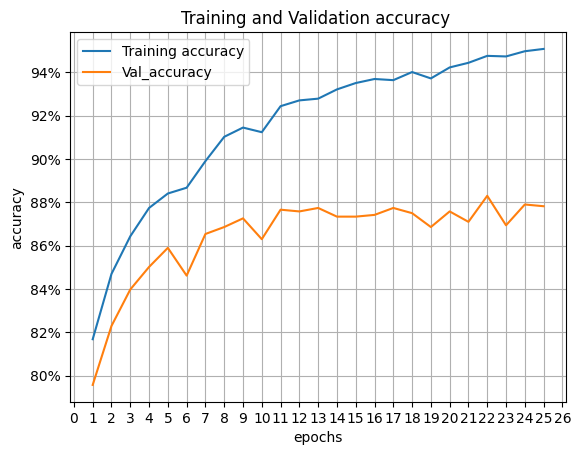

In [ ]:
epochs = np.arange(25) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_accuracies , label='Training accuracy')
plt.plot(epochs, val_accuracies, label='Val_accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation accuracy ')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()

In [ ]:
epochs = np.arange(25) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_loss , label='Training loss')
plt.plot(epochs, val_loss, label='Val_loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation loss VGG16')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in plt.gca().get_yticks()])/
plt.grid('off')
plt.show()

NameError: ignored